In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras import backend as K, metrics
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()
n = 2
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = False
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666665
 |>  150


In [5]:
n = 100
min_f = 3
max_f = 20
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
y_train = x_train

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0020833333333368
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0000000000000027
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9958333333333367
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.016666666666665
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9906250000000036
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.995833333333332
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0083333333333355
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0010416666666657
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.010416666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.990625000000001
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9979166666666672
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9968750000000024
 |>  150
 [DEBUG]

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0010416666666693
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0000000000000013
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9916666666666676
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.01979166666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.99375
 |>  150


In [6]:
x_train.shape

(283, 150, 1)

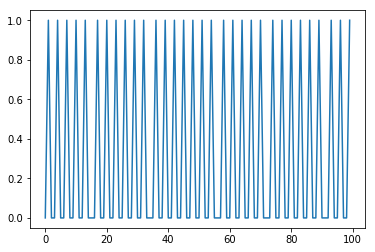

In [7]:
plt.plot(x_train[0,:100])

In [8]:
x_train.shape

(283, 150, 1)

In [9]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 150
input_shape

(150, 1)

In [10]:
output_shape

(150, 1)

In [11]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [12]:
k_reg = regularizers.l2(0.01) # 10e-5
# b_reg = regularizers.l1(0.01)
a_reg = regularizers.l1(0.01) # 10e-5

In [13]:
input_shape
# input_shape = (150,)
input_shape

(150, 1)

In [14]:
batch_size = 16
original_dim = 150
latent_dim = 2
intermediate_dim = 150
epsilon_std = 1.0

In [118]:
def sampling(args, latent_dim, epsilon_std):
    z_mean, z_log_var = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [158]:
def encoder(latent_dim, input_shape, intermediate_dim = 150):
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    y = encoder_input
    y = Reshape(input_shape[:1])(y) # Flatten() nees 3 dims
    h = Dense(intermediate_dim, activation='relu', name='encoder_h-')(y)
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, z_mean, z_log_var, encoder_input

def z_(latent_dim, epsilon_std):
    # sample z from a distribution defined by [input_mean, input_log_var]
    # input :: [z_mean, z_log_var]
    z_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
    sampling_ = lambda args: sampling(args, latent_dim, epsilon_std)
    z_output = Lambda(sampling_, name='z_sampler-')(z_input)
    # z_output = Lambda(sampling_, output_shape=(latent_dim,), name='z_sampler-')(z_input)
    z_model = Model(z_input, z_output, name='z_model-')
    return z_model

def decoder(latent_dim, input_shape, intermediate_dim = 150):
    z = Input(shape=(latent_dim,), name='decoder_input-')
    decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h-')
    h = decoder_h(z)
    decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean-')
    x_decoded_mean = decoder_mean(h)
    h = Reshape(input_shape)(x_decoded_mean)
    decoder_output = h
    model = Model(inputs=z, outputs=decoder_output, name='decoder_model-')
    return model

In [182]:
encoder_model, z_mean, z_log_var, encoder_input = encoder(latent_dim, input_shape)
z_model = z_(latent_dim, epsilon_std)
decoder_model = decoder(latent_dim, input_shape)

vae_input = Input(shape=input_shape)
# vae_input = Input(shape=(150,1))
vae_input = encoder_input # WHY ?
vae_output = decoder_model(z_model(encoder_model(vae_input)))
# vae_output = decoder_model(z)
vae = Model(vae_input, vae_output)
# vae = Model(encoder_input, decoder_model(z))
# vae = Model(encoder_input, decoder_output)
encoder_model.summary()
z_model.summary()
decoder_model.summary()
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
reshape_29 (Reshape)            (None, 150)          0           encoder_input-[0][0]             
__________________________________________________________________________________________________
encoder_h- (Dense)              (None, 150)          22650       reshape_29[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            302         encoder_h-[0][0]                 
__________________________________________________________________________________________________
z_log_var 

In [183]:
# xent_loss = original_dim * keras.metrics.binary_crossentropy(vae_input, vae_output)
# xent_loss = keras.metrics.binary_crossentropy(vae_input, vae_output)
xent_loss = np.prod(input_shape) * keras.metrics.binary_crossentropy(vae_input, vae_output)
# kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
kl_loss = - 0.5 * K.sum(1 + K.flatten(z_log_var) - K.square(K.flatten(z_mean)) - K.exp(K.flatten(z_log_var)), axis=-1)

# kl_loss = - 0.5 * K.sum(1 + 0 - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# kl_loss = K.sum(K.mean(z_mean) + K.exp(z_log_var), axis=-1)
# kl_loss = K.max([K.max(z_mean), K.max(z_log_var)])
# kl_loss = K.square(K.flatten(z_mean))
# kl_loss = K.square(z_mean) - K.exp(z_log_var)

# vae_loss = K.mean(xent_loss)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.


In [184]:
# z_train = x_train
# x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(43, 150, 1)

In [185]:
x_test = x_train[-10:]
x_train = x_train[:-10]

In [186]:
epochs = 100
m = 50
# , validation_data=(x_test, None)
history = vae.fit(x_train[:m], shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 33 samples, validate on 10 samples
Epoch 1/100
33/33 [==============================] - 1s 45ms/step - loss: 107.5042 - val_loss: 104.1697
Epoch 2/100
33/33 [==============================] - 0s 291us/step - loss: 104.0982 - val_loss: 103.9519
Epoch 3/100
33/33 [==============================] - 0s 297us/step - loss: 103.2529 - val_loss: 101.9634
Epoch 4/100
33/33 [==============================] - 0s 342us/step - loss: 101.8761 - val_loss: 101.0323
Epoch 5/100
33/33 [==============================] - 0s 417us/step - loss: 101.0799 - val_loss: 101.3793
Epoch 6/100
33/33 [==============================] - 0s 862us/step - loss: 100.3195 - val_loss: 101.5475
Epoch 7/100
33/33 [==============================] - 0s 761us/step - loss: 100.4130 - val_loss: 101.7777
Epoch 8/100
33/33 [==============================] - 0s 519us/step - loss: 99.4224 - val_loss: 99.7260
Epoch 9/100
33/33 [==============================] - 0s 668us/step - loss: 99.8167 - val_loss: 99.1521
Epoch 10/100
33/

33/33 [==============================] - 0s 532us/step - loss: 94.3300 - val_loss: 88.1051
Epoch 80/100
33/33 [==============================] - 0s 584us/step - loss: 88.6795 - val_loss: 93.5291
Epoch 81/100
33/33 [==============================] - 0s 577us/step - loss: 92.1645 - val_loss: 88.6105
Epoch 82/100
33/33 [==============================] - 0s 412us/step - loss: 91.4696 - val_loss: 91.3294
Epoch 83/100
33/33 [==============================] - 0s 453us/step - loss: 94.3581 - val_loss: 88.4837
Epoch 84/100
33/33 [==============================] - 0s 444us/step - loss: 89.8418 - val_loss: 93.6090
Epoch 85/100
33/33 [==============================] - 0s 444us/step - loss: 89.7025 - val_loss: 92.8660
Epoch 86/100
33/33 [==============================] - 0s 435us/step - loss: 90.9556 - val_loss: 92.3391
Epoch 87/100
33/33 [==============================] - 0s 373us/step - loss: 91.2943 - val_loss: 87.8883
Epoch 88/100
33/33 [==============================] - 0s 415us/step - loss: 9

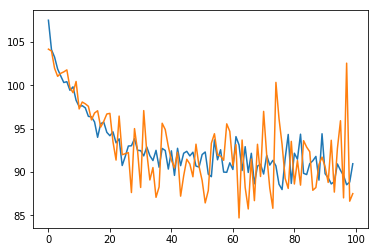

In [187]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [188]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

In [189]:
# plot_model(vae, to_file='model.png')

In [190]:
generator = decoder_model # decoder_model(z)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input- (InputLayer)  (None, 2)                 0         
_________________________________________________________________
decoder_h- (Dense)           (None, 150)               450       
_________________________________________________________________
decoder_mean- (Dense)        (None, 150)               22650     
_________________________________________________________________
reshape_30 (Reshape)         (None, 150, 1)            0         
Total params: 23,100
Trainable params: 23,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [ ]:
plt.plot(x_train[0,:100,:])

In [ ]:
result.shape

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)